In [1]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport

In [2]:
# Note: this is dangerous since we don't know what we import, but it's a lazy 
# and definitely the most compact way to get all constants:
from parameters import *
# Just make sure to put only global constants in that file, which are not going to be
# confused with parameters that are susceptible to change, such as resolution

In [3]:
# load the velocity field:
data_vel = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
u,v = np.load(data_vel)
"""
fig, ax = plt.subplots(figsize=(4,4))
ax.quiver(u.T, v.T)
ax.set_title('velocity field')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
""";

**species and temperature**

Define the different species

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
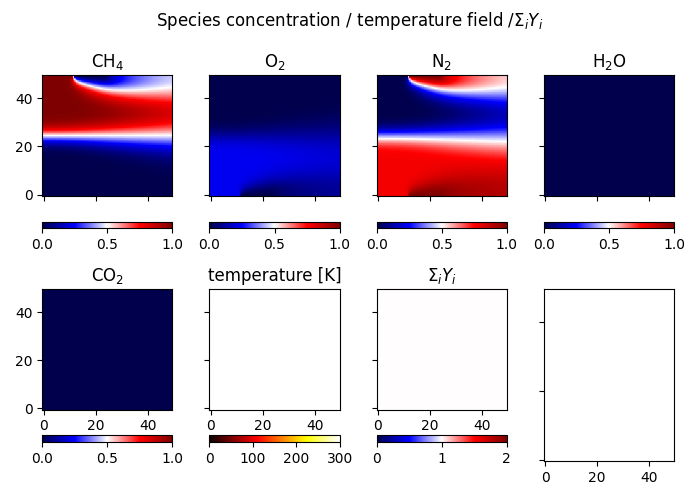

In [4]:
%autoreload 1

data_sp = Path('data/species') / 'N{}M{}.npy'.format(N,M)

species_data = np.load(data_sp)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]

from visualization import plot_species_overview
#fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
#plot_species_overview(Y,T, axs=axs)

### Combustion

In [5]:
%autoreload 1
from species_transport import Y_to_n, get_Q, W, nu_stoch, dh0, advance_chem, integr_chem_2d
from species_transport import BCs, set_Temp_BC
from Funcs import advance_adv_diff_RK4

dt = 1e-6

def evolve_species_revisited(Y, T, Nt, evolve_T=True):
     
    nspec = Y.shape[0]
    kspec = np.arange(nspec)
    
    for n in range(Nt):
        
        Nt_chem = 100 if evolve_T else 100
        Y, _ = integr_chem_2d(Y, T, dt, Nt_chem, evolve_T)
        if evolve_T:
            T = _
            
            # (almost) same procedure for temperature as for species:
            T = advance_adv_diff_RK4(T, dt, u, v, dx, dy, nu)
            T = set_Temp_BC(T)
            
        for k in kspec:
            # apply BCs
            Y[k] = BCs[k](Y[k])
            
            if k in kspec[:-1]:
                Y[k] = advance_adv_diff_RK4(Y[k], dt, u, v, dx, dy, nu)
                
            else:
                # normalization condition:
                Y[k] = 1 + Y[k] - np.sum(Y, axis=0)
            Y[k] = BCs[k](Y[k])
            
    return Y, T

Here is the workflow: first, we inititate the transport as done previously:

Now we impose a temperature of 1000 in the center of the chamber

In [6]:
T = np.ones((N,M)) * 300

Th_thick = 0.05*10**-3
Th_band = np.array([T.shape[1]/2-Th_thick/dy,
                    T.shape[1]/2+Th_thick/dy],dtype=int)

T[:,Th_band[0]:Th_band[1]] = 1000
"""
plt.figure()
plt.imshow(T.T,cmap="seismic")
plt.title("Temperature distribution in first frame")
plt.colorbar()
plt.show()
""";

Evolve chemistry (while keeping $T$ constant)

In [7]:
Nt = 500
%time Y, _ = evolve_species_revisited(Y,T,Nt, evolve_T=False);

CPU times: user 17.2 s, sys: 63.4 ms, total: 17.3 s
Wall time: 17.2 s


We check that CO2 and H2O have been indeed been created in the center of the cell.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
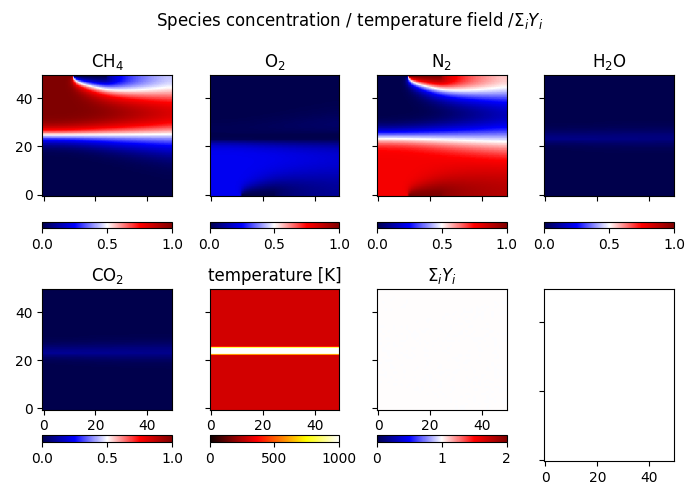

In [8]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Once the ignition has stabilized, add the temperature evolution (does not seem to work yet if we uncomment the lines above).

In [9]:
Nt = 300
Y, T = evolve_species_revisited(Y,T,Nt, evolve_T=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
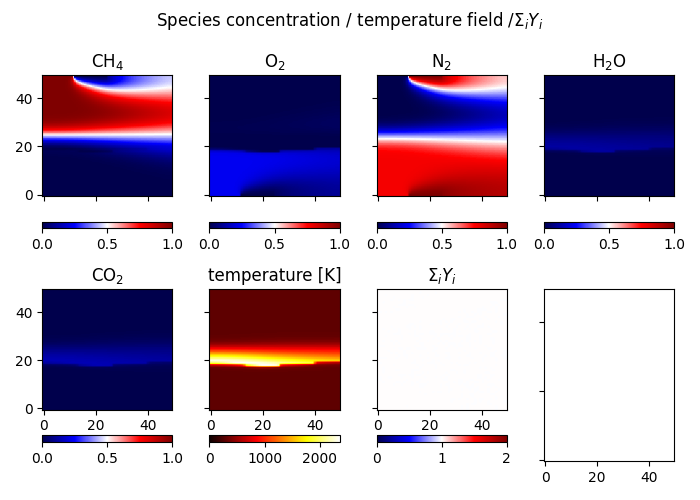

In [10]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)